# Rekomendasi Unsupervised Lbl2vec

In [1]:
from google_play_scraper import app
from google_play_scraper import Sort, reviews
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lbl2vec import Lbl2Vec
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import strip_tags
from sklearn.metrics import f1_score
from tqdm import tqdm

tqdm.pandas()

In [3]:
result, continuation_token = reviews(
    'com.dafturn.mypertamina',
    lang='id', 
    country='id', 
    sort=Sort.MOST_RELEVANT, 
    count=114904, 
    filter_score_with=None
)

In [7]:
df = pd.DataFrame.from_dict(result)
df = df[['userName', 'score','at', 'content']]

In [8]:
import re
def cleaningulasan(ulasan):
  ulasan = re.sub(r'@[A-Za-a0-9]+',' ',ulasan)
  ulasan = re.sub(r'#[A-Za-z0-9]+',' ',ulasan)
  ulasan = re.sub(r"http\S+",' ',ulasan)
  ulasan = re.sub(r'[0-9]+',' ',ulasan)
  ulasan = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", ulasan)
  ulasan = ulasan.strip(' ')
  return ulasan

def clearEmoji(ulasan):
    return ulasan.encode('ascii', 'ignore').decode('ascii')

def replaceTOM(ulasan):
    pola = re.compile(r'(.)\1{2,}', re.DOTALL)
    return pola.sub(r'\1', ulasan)

def casefoldingText(ulasan):
  ulasan = ulasan.lower()
  return ulasan

In [9]:
df['Cleaning']= df['content'].apply(cleaningulasan)
df['HapusEmoji']= df['Cleaning'].apply(clearEmoji)
df['3/Lebih']= df['HapusEmoji'].apply(replaceTOM)
df['CaseFolding']= df['3/Lebih'].apply(casefoldingText)

In [10]:
def convertToSlangword(ulasan):
    kamusSlang = eval(open("NLP_bahasa_resources\combined_slang_words.txt").read())
    content = []
    for kata in ulasan.split():
        try:
            content.append(kamusSlang[kata])
        except:
            content.append(kata)
    ulasan = ' '.join(content)
    return ulasan

df['Formalisasi'] = df['CaseFolding'].apply(convertToSlangword)

In [2]:
df = pd.read_csv('review_mobile_jkn_processed.csv')

In [21]:
positive = pd.read_csv('InSet\positive.tsv', sep='\t', index_col='word')
negative = pd.read_csv('InSet\\negative.tsv', sep='\t', index_col='word')

# inset = pd.concat([positive, negative]).to_dict()['weight']
positive = positive.to_dict()['weight']
negative = negative.to_dict()['weight']

In [22]:
def sentiment_score(ulasan):
    inset_positive_score = 0
    inset_negative_score = 0

    for kata in str(ulasan).split():
        try:
            inset_positive_score += positive[kata]
        except:
            inset_positive_score += 0
        
        try:
            inset_negative_score += negative[kata]
        except:
            inset_negative_score += 0

    return inset_positive_score + inset_negative_score

df['sentiment_score'] = df['CaseFolding'].progress_apply(sentiment_score)

100%|██████████| 114904/114904 [00:02<00:00, 44064.64it/s] 


In [3]:
df = df[['userName', 'score','at', 'content', 'Formalisasi', 'sentiment_score']]
df

,userName,score,at,content,Formalisasi,sentiment_score
0,Setiawan Jodi,1,2022-10-03 05:19:36,Saat login kode capchta tidak muncul jaringan ...,saat login kode capchta tidak muncul jaringan ...,-23
1,Sri Astuti,1,2022-09-27 04:34:32,"Aplikasi yg gak jelas, hal yg mudah dibuat jd ...",aplikasi yang gak jelas hal yang mudah dibuat ...,0
2,Pratiwi R,2,2022-10-03 07:16:04,Aplikasi nya kurang bagus versi sekarang... Ma...,aplikasi nya kurang bagus versi sekarang mau l...,-10
3,adnan maulana,5,2022-10-03 00:47:33,"Kekurangannya, tidak seluruh Bank tersedia unt...",kekurangannya tidak seluruh bank tersedia untu...,12
4,Indria Mandala Putri,1,2022-10-03 09:50:28,Di satu sisi aplikasi ini bagus dan memudahkan...,di satu sisi aplikasi ini bagus dan memudahkan...,-17
...,...,...,...,...,...,...
124592,Pengguna Google,5,2016-10-28 11:48:57,Ok,ok,4
124593,Suprapto Rtku,5,2022-06-08 04:17:08,Setiyasih Setiyasih,setiyasih setiyasih,0
124594,Pengguna Google,5,2016-07-29 14:12:34,Good,good,5
124595,Pengguna Google,5,2016-10-27 12:12:42,Good,good,5


## Value Count by Score

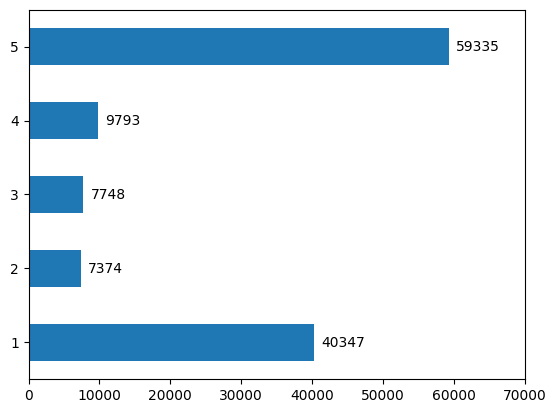

In [4]:
ax = df['score'].value_counts().sort_index().plot(kind='barh')
ax.bar_label(ax.containers[0], padding=5)
ax.set_xlim(right=70000)

plt.show()

In [24]:
# df.to_csv('review_mypertamina.csv', index=False)

In [25]:
# df = pd.read_csv('review_mypertamina.csv')

In [62]:
labels = pd.read_csv('label_keyword_jkn.csv',sep=';')
labels['keywords'] = labels['keywords'].apply(lambda x: x.lower().split(' '))
labels['number_of_keywords'] = labels['keywords'].apply(lambda row: len(row))

In [63]:
labels

,class_index,class_name,keywords,number_of_keywords
0,1,user_experience,"[ribet, good, baik, memudahkan, best, mempermu...",25
1,2,server,"[server, operation, time, out, loading, ganggu...",7
2,3,payment,"[bank, banking, pembayaran, bayar, auto, debit...",9
3,5,authentication,"[login, email, masuk, terdaftar, daftar, regis...",15
4,6,account,"[edit, profile, password, logout]",4
5,7,family_members,"[penambahan, data, keluarga, anggota, peserta,...",10


In [32]:
def tokenize(doc):
    return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)

In [33]:
df.head()

,userName,score,at,content,Formalisasi,sentiment_score,tagged_docs,doc_key
0,Setiawan Jodi,1,2022-10-03 05:19:36,Saat login kode capchta tidak muncul jaringan ...,saat login kode capchta tidak muncul jaringan ...,-23,"([saat, login, kode, capchta, tidak, muncul, j...",0
1,Sri Astuti,1,2022-09-27 04:34:32,"Aplikasi yg gak jelas, hal yg mudah dibuat jd ...",aplikasi yang gak jelas hal yang mudah dibuat ...,0,"([aplikasi, yang, gak, jelas, hal, yang, mudah...",1
2,Pratiwi R,2,2022-10-03 07:16:04,Aplikasi nya kurang bagus versi sekarang... Ma...,aplikasi nya kurang bagus versi sekarang mau l...,-10,"([aplikasi, nya, kurang, bagus, versi, sekaran...",2
3,adnan maulana,5,2022-10-03 00:47:33,"Kekurangannya, tidak seluruh Bank tersedia unt...",kekurangannya tidak seluruh bank tersedia untu...,12,"([kekurangannya, tidak, seluruh, bank, tersedi...",3
4,Indria Mandala Putri,1,2022-10-03 09:50:28,Di satu sisi aplikasi ini bagus dan memudahkan...,di satu sisi aplikasi ini bagus dan memudahkan...,-17,"([di, satu, sisi, aplikasi, ini, bagus, dan, m...",4


In [34]:
# sum(df['Formalisasi'].isna())

In [35]:
df['Formalisasi'] = df['Formalisasi'].fillna('').astype(str)
df['tagged_docs'] = df.progress_apply(lambda row: TaggedDocument(tokenize(row['Formalisasi']), [str(row.name)]), axis=1)

100%|██████████| 124597/124597 [00:12<00:00, 9918.98it/s] 


In [36]:
df.head()

,userName,score,at,content,Formalisasi,sentiment_score,tagged_docs,doc_key
0,Setiawan Jodi,1,2022-10-03 05:19:36,Saat login kode capchta tidak muncul jaringan ...,saat login kode capchta tidak muncul jaringan ...,-23,"([saat, login, kode, capchta, tidak, muncul, j...",0
1,Sri Astuti,1,2022-09-27 04:34:32,"Aplikasi yg gak jelas, hal yg mudah dibuat jd ...",aplikasi yang gak jelas hal yang mudah dibuat ...,0,"([aplikasi, yang, gak, jelas, hal, yang, mudah...",1
2,Pratiwi R,2,2022-10-03 07:16:04,Aplikasi nya kurang bagus versi sekarang... Ma...,aplikasi nya kurang bagus versi sekarang mau l...,-10,"([aplikasi, nya, kurang, bagus, versi, sekaran...",2
3,adnan maulana,5,2022-10-03 00:47:33,"Kekurangannya, tidak seluruh Bank tersedia unt...",kekurangannya tidak seluruh bank tersedia untu...,12,"([kekurangannya, tidak, seluruh, bank, tersedi...",3
4,Indria Mandala Putri,1,2022-10-03 09:50:28,Di satu sisi aplikasi ini bagus dan memudahkan...,di satu sisi aplikasi ini bagus dan memudahkan...,-17,"([di, satu, sisi, aplikasi, ini, bagus, dan, m...",4


In [37]:
df['doc_key'] = df.index.astype(str)

In [45]:
doc2vec_model = Doc2Vec(documents=df['tagged_docs'], dbow_words=1, dm=1)

In [46]:
doc2vec_model.save('doc2vec_mobileJKN_model')

In [64]:
Lbl2Vec_model = Lbl2Vec(keywords_list=list(labels.keywords),  doc2vec_model=doc2vec_model, label_names=list(labels.class_name), similarity_threshold=0.43, min_num_docs=100, epochs=50)

Lbl2Vec_model.fit()

2022-10-14 19:55:19,707 - Lbl2Vec - INFO - Load document and word embeddings
2022-10-14 19:55:19,710 - Lbl2Vec - INFO - Train label embeddings
2022-10-14 19:55:20,590 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: operation


In [65]:
model_docs_lbl_similarities = Lbl2Vec_model.predict_model_docs()

2022-10-14 19:55:26,703 - Lbl2Vec - INFO - Get document embeddings from model
2022-10-14 19:55:27,006 - Lbl2Vec - INFO - Calculate document<->label similarities


In [59]:
model_docs_lbl_similarities = model_docs_lbl_similarities.merge(df, left_on='doc_key', right_on='doc_key')#[['content','most_similar_label']]

In [60]:
model_docs_lbl_similarities[['content', 'most_similar_label']]

,content,most_similar_label
0,Saat login kode capchta tidak muncul jaringan ...,authentication
1,"Aplikasi yg gak jelas, hal yg mudah dibuat jd ...",security
2,Aplikasi nya kurang bagus versi sekarang... Ma...,security
3,"Kekurangannya, tidak seluruh Bank tersedia unt...",family_members
4,Di satu sisi aplikasi ini bagus dan memudahkan...,security
...,...,...
124592,Ok,security
124593,Setiyasih Setiyasih,authentication
124594,Good,security
124595,Good,security


In [54]:
model_docs_lbl_similarities[model_docs_lbl_similarities['most_similar_label'] == 'server'][['content']]

,content
2,Aplikasi nya kurang bagus versi sekarang... Ma...
4,Di satu sisi aplikasi ini bagus dan memudahkan...
5,"Aplikasi teerrrribet, paling sering minta upda..."
9,"Aplikasi kurang efektif, terlalu banyak konten..."
12,sudah update lagi..tapi tetep masih ada fitur ...
...,...
124589,Tes
124590,Ok
124591,Ok
124592,Ok


[Text(0, 0, '109275'),
 Text(0, 0, '3692'),
 Text(0, 0, '2723'),
 Text(0, 0, '2702'),
 Text(0, 0, '2557'),
 Text(0, 0, '2334'),
 Text(0, 0, '1314')]

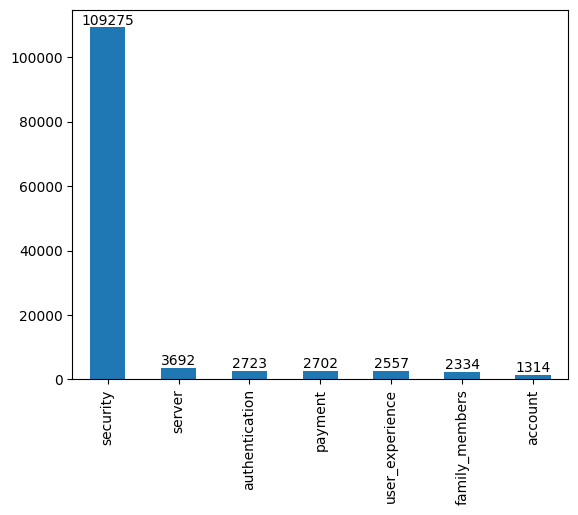

In [61]:
ax = model_docs_lbl_similarities[model_docs_lbl_similarities['most_similar_label'] != 'invalid_troll']['most_similar_label'].value_counts().plot(kind='bar')
ax.bar_label((ax.containers[0]))

In [50]:
sentiment_dict = {}
for i in model_docs_lbl_similarities.iterrows():
    sentiment_dict[i[1]['most_similar_label']] = sentiment_dict.get(i[1]['most_similar_label'], 0) + i[1]['sentiment_score']
    # break

In [51]:
sentiment_df = pd.DataFrame([val for _, val in sentiment_dict.items()], index=sentiment_dict.keys(), columns=['sentiment_score'])

[Text(0, 0, '48481'),
 Text(0, 0, '23236'),
 Text(0, 0, '22680'),
 Text(0, 0, '18084'),
 Text(0, 0, '16846'),
 Text(0, 0, '15633'),
 Text(0, 0, '9060'),
 Text(0, 0, '9007')]

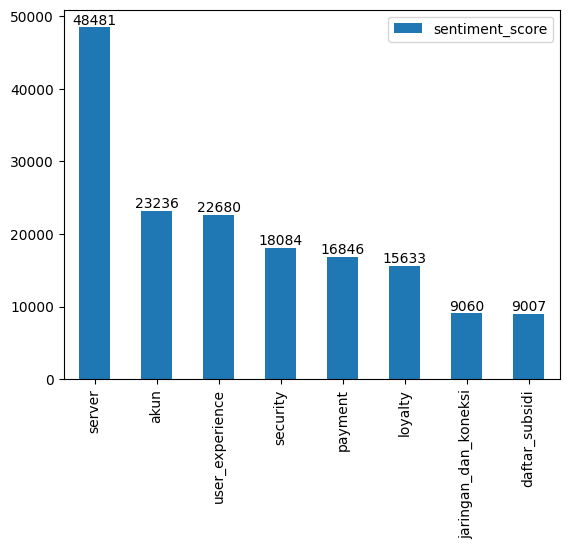

In [52]:
ax = np.abs(sentiment_df.sort_values('sentiment_score'))[1:].plot.bar()
ax.bar_label((ax.containers[0]))

In [53]:
model_docs_lbl_similarities.to_csv('model_docs_lbl_similarities.csv', index=False)

In [54]:
Lbl2Vec_model.save('Lbl2Vec_model')